In [ ]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, warnings

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
#ignore warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
#matplotlib inline
df = pd.read_json('C:\\Users\\Win 1809 UEFI\\Desktop\\4.json')
#print(df.review.unique())
df.head()
# Convert to list
data = df.review.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#pprint(data[:1])
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words[:1])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])
vectorizer = CountVectorizer(analyzer='word',
                             min_df=10,                        # minimum reqd occurences of a word
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

#print(lda_model)  # Model attributes

C:\Users\Win 1809 UEFI\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2003163.0216032874
Perplexity:  715.9651917283385
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [3]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [4]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -691541.5418594899
Model Perplexity:  682.1199821344964


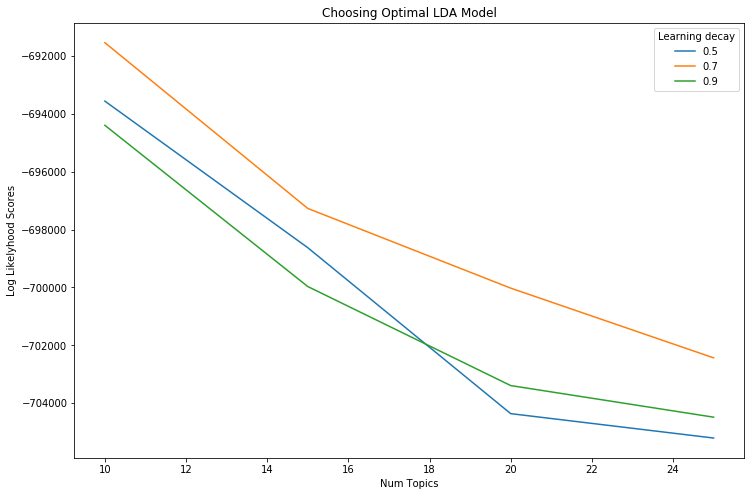

In [6]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [6]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(10)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0.32,0.07,0,0.44,0,0,0,0.15,0,4
Doc1,0.11,0.55,0.32,0,0,0,0,0,0,0,1
Doc2,0,0.59,0,0,0,0,0.05,0,0.33,0,1
Doc3,0,0.6,0.03,0,0,0.26,0.05,0,0.06,0,1
Doc4,0,0.71,0.13,0.1,0.05,0,0,0,0,0,1
Doc5,0,0.32,0.04,0,0.33,0,0,0,0.3,0,4
Doc6,0,0.87,0,0,0,0,0,0.11,0,0,1
Doc7,0,0.96,0,0,0,0,0,0,0,0,1
Doc8,0,0.94,0.05,0,0,0,0,0,0,0,1
Doc9,0,0.47,0,0,0,0,0,0,0.51,0,8


,Topic Num,Num Documents
0,7,2049
1,1,1041
2,4,1027
3,8,481
4,0,228
5,3,21
6,5,3
7,6,2


In [8]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Win 1809 UEFI\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      103.314400  -67.649734       1        1  28.894374
4        2.104542  -68.393044       2        1  21.975100
1       17.069267   88.429642       3        1  21.416261
8      -81.700005   83.278366       4        1  13.499394
0      -37.421787    3.138733       5        1   6.404406
3       46.389046 -148.528641       6        1   2.664754
5     -138.626404    2.399285       7        1   2.060902
6      -52.380787 -153.682999       8        1   1.235240
9      -98.054955  -77.051659       9        1   0.942452
2       62.734867   11.795290      10        1   0.907118, topic_info=     Category          Freq       Term         Total  loglift  logprob
term                                                                  
1160  Default   1972.000000   istanbul   1972.000000  30.0000  30.0000
68    Default   4148.000000    airline   4148.000000  29.0000  29.0000
2253  Default   1706.000000    turkish   1706.000000  28.0000  28.0000
1295  Default   1399.000000     lounge   1399.000000  27.0000  27.0000
746   Default   1966.000000    emirate   1966.000000  26.0000  26.0000
891   Default  10653.000000     flight  10653.000000  25.0000  25.0000
408   Default   2310.000000      class   2310.000000  24.0000  24.0000
318   Default   2117.000000   business   2117.000000  23.0000  23.0000
63    Default    773.000000        air    773.000000  22.0000  22.0000
1443  Default   1182.000000        new   1182.000000  21.0000  21.0000
152   Default   1406.000000        ask   1406.000000  20.0000  20.0000
2197  Default   1141.000000     ticket   1141.000000  19.0000  19.0000
903   Default   3122.000000       food   3122.000000  18.0000  18.0000
553   Default   2461.000000       crew   2461.000000  17.0000  17.0000
973   Default   4220.000000       good   4220.000000  16.0000  16.0000
1061  Default   3152.000000       hour   3152.000000  15.0000  15.0000
597   Default   1442.000000      delay   1442.000000  14.0000  14.0000
1913  Default   4898.000000       seat   4898.000000  13.0000  13.0000
1570  Default    984.000000        pay    984.000000  12.0000  12.0000
368   Default    801.000000     change    801.000000  11.0000  11.0000
2060  Default   2672.000000      staff   2672.000000  10.0000  10.0000
1210  Default    352.000000     kuwait    352.000000   9.0000   9.0000
324   Default   2059.000000      cabin   2059.000000   8.0000   8.0000
678   Default   1139.000000       doha   1139.000000   7.0000   7.0000
70    Default   2242.000000    airport   2242.000000   6.0000   6.0000
2342  Default   1088.000000       wait   1088.000000   5.0000   5.0000
1662  Default    443.000000      price    443.000000   4.0000   4.0000
2175  Default   1399.000000       tell   1399.000000   3.0000   3.0000
894   Default   2767.000000        fly   2767.000000   2.0000   2.0000
725   Default   1056.000000    economy   1056.000000   1.0000   1.0000
...       ...           ...        ...           ...      ...      ...
1308  Topic10    156.948851     lumpur    157.857413   4.6969  -2.8686
95    Topic10    160.326621      amman    161.269088   4.6968  -2.8473
1865  Topic10    101.179497      royal    102.090548   4.6937  -3.3076
1180  Topic10     98.956887  jordanian     99.868568   4.6935  -3.3298
2173  Topic10     69.505144        tel     70.423474   4.6895  -3.6831
188   Topic10     67.384690       aviv     68.293838   4.6893  -3.7141
135   Topic10     54.354935     arabia     55.265438   4.6860  -3.9290
1410  Topic10     48.286966     moscow     49.225646   4.6834  -4.0474
1352  Topic10     40.400248        mct     41.308877   4.6804  -4.2257
1194  Topic10     38.187696       kiev     39.096824   4.6791  -4.2820
2330  Topic10     57.929111     vienna     59.721117   4.6722  -3.8653
1323  Topic10     28.918200   malaysia     29.826748   4.6717  -4.5600
1851  Topic10     28.520835     riyadh     29.429308   4.6713  -4.

In [9]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ababa,ability,able,abreast,abrupt,absence,absolute,absolutely,abu,abuja,...,write,wrong,year,yell,yesterday,york,youa,young,zone,zurich
Topic0,2.729721,0.100041,10.353458,0.100019,5.241231,0.100024,0.100044,8.050528,0.100678,0.100036,...,0.100061,0.130972,30.319820,0.100051,6.344198,0.100029,0.100009,22.316329,0.100018,0.100019
Topic1,15.234048,0.100072,188.238096,0.100004,0.100052,0.100009,0.100066,64.090702,182.140776,36.058303,...,108.850914,70.308677,220.227017,9.438285,19.690080,0.108597,0.100275,17.374455,14.327607,0.100018
Topic2,0.100123,0.100012,0.100021,0.100044,0.101319,0.100034,0.100015,0.100022,0.100032,0.100045,...,0.100025,0.100019,0.100052,0.100017,0.100026,0.100008,0.100015,0.100021,0.100010,0.100025
Topic3,0.108138,0.100011,15.351033,0.100003,0.100053,12.377151,0.100039,0.100021,0.100219,0.100033,...,2.023068,0.100029,0.100061,0.100010,0.106070,0.100251,10.919878,0.100699,0.100016,0.100004
Topic4,0.100036,0.100027,113.676348,0.100039,0.666274,0.100074,0.100163,0.100024,0.145341,0.100010,...,0.100066,0.909189,11.691745,0.100047,0.100020,0.100011,0.100015,6.754274,38.673531,0.100364


In [10]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,istanbul,turkish,flight,airline,crew,staff,food,airport,cabin,good,plane,time,passenger,attendant,service
Topic 1,flight,airline,check,ticket,day,luggage,tell,customer,pay,service,time,airport,fly,book,seat
Topic 2,air,bahrain,gulf,amman,kuala,lumpur,royal,jordanian,tel,aviv,vienna,milan,arabia,moscow,mct
Topic 3,ask,emirate,class,upgrade,business,water,card,mile,mumbai,credit,member,economy,offer,toronto,know
Topic 4,seat,flight,meal,serve,business,time,class,good,crew,cabin,drink,food,check,passenger,board
Topic 5,lounge,access,auh,english,high,doha,restaurant,clean,doh,shower,flight,area,star,warm,fish
Topic 6,jfk,york,new,ticket,sale,traveler,frequent,change,price,purchase,city,johannesburg,barcelona,add,business
Topic 7,good,flight,service,food,fly,seat,qatar,crew,time,airline,airway,class,cabin,emirate,great
Topic 8,flight,hour,delay,airport,wait,staff,gate,passenger,time,tell,minute,hotel,miss,arrive,connect
Topic 9,kuwait,muscat,oman,air,stick,clearly,houston,munich,auckland,tokyo,san,francisco,bangalore,paulo,usa


In [11]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['ask', 'emirate', 'class', 'upgrade', 'business', 'water', 'card', 'mile', 'mumbai', 'credit', 'member', 'economy', 'offer', 'toronto', 'know']


In [12]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.11  0.24  0.02  0.04  0.37  0.04  0.02  0.88  0.14  0.02]
 [ 0.09  0.85  0.01  0.04  0.15  0.01  0.02 -0.36  0.32  0.01]]
Perc of Variance Explained: 
 [0.16 0.35]


Text(0.5,1,'Segregation of Topic Clusters')

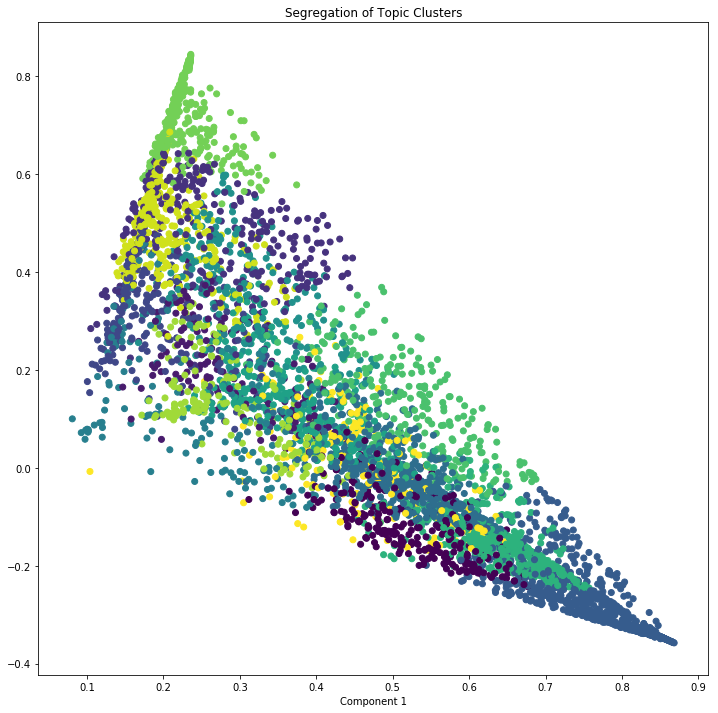

In [13]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [15]:
# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['ask', 'emirate', 'class', 'upgrade', 'business', 'water', 'card', 'mile', 'mumbai', 'credit', 'member', 'economy', 'offer', 'toronto', 'know']
Topic Prob Scores of text:  [[0.1 0.1 0.1 0.5 0.1 0.1 0.1 0.1 0.1 0.1]]
Most Similar Doc's Probs:   [[0.2 0.  0.  0.5 0.  0.  0.1 0.2 0.  0. ]]

 Where is the service heading? Does their management know? The AVML food on this route specially from JFK is horrible. Staff are becoming lazy and so talkative amongst themselves rather than focussing on the service. Water bottles are so small you have to keep asking for water and then an attitude is shown to you by the staff. I know this is a growing airline but if the growth is not controlled it will be a downfall for them soon.
